In [31]:
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display
import soundfile as sf # librosa fails when reading files on Kaggle.

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [32]:
audio_path = './sound_extract/0_footstep.wav'
ipd.Audio(audio_path)

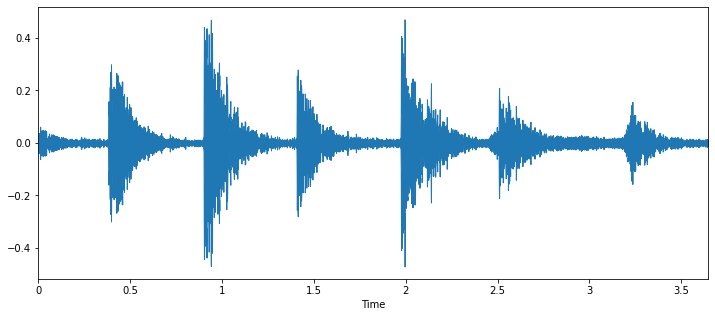

In [33]:
# Extract the audio data (x) and the sample rate (sr).
x, sr = librosa.load(audio_path)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [34]:
print(sr)

22050


Number of crosses: 6


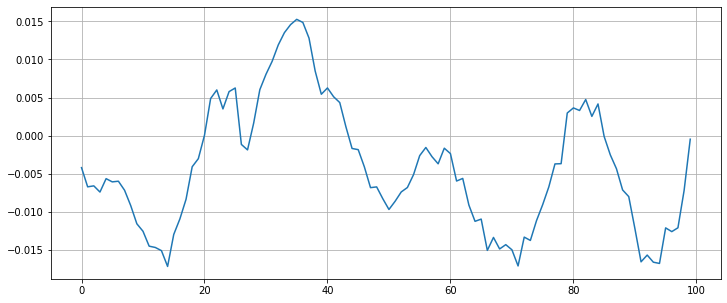

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(x[1000:1100]) # Zoom-in for seeing the example.
plt.grid()

n_crossings = librosa.zero_crossings(x[1000:1100], pad=False)
print(f'Number of crosses: {sum(n_crossings)}')

In [36]:
centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

print(f'Centroids Shape: {centroids.shape}')
print(f'First 3 centroids: {centroids[:3]}')

Centroids Shape: (158,)
First 3 centroids: [1578.1571884  1525.09992213 1589.0745862 ]


MFFCs shape: (20, 158)
First mffcs: [-281.91293 -281.85254 -293.41507 -299.45285 -304.50296]


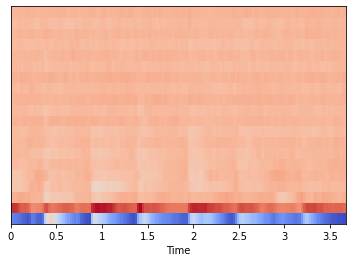

In [37]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(f'MFFCs shape: {mfccs.shape}')
print(f'First mffcs: {mfccs[0, :5]}')

# We can even display an spectogram of the mfccs.
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

In [61]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios():
    train_path = "./sound_extract/"
    train_file_names = os.listdir(train_path)
    train_file_names.sort(key=lambda x: int(x.partition('_')[0]))
    
    samples = []
    for file_name in train_file_names:
        x, sr = sf.read(train_path + file_name, always_2d=True)
        if not len(x) == 0:
            x = parse_audio(x)
            samples.append(mean_mfccs(x))
        else:
            print(file_name)
    return np.array(samples)

def get_samples():
    df = pd.read_csv('./event_data_preprocesssing_jjin_real_final.csv')
    return get_audios(), df['event'].values

In [62]:
X, Y = get_samples()

# Since the data manufacturer doesn't provide the labels for the test audios,
# we will have do the split for the labeled data.
x_train, x_test, y_train, y_test = train_test_split(X, Y)

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1733
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1734
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1732
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1633
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=299
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1613
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/

In [58]:
os.remove("./sound_extract/" + '9536_footstep.wav')

In [67]:
print(f'Shape: {x_train.shape}')
print(f'Observation: \n{x_train[0]}')
print(f'Labels: {y_train[:5]}')

Shape: (11891, 20)
Observation: 
[-5.66603010e+02  1.47497328e+02  9.25066260e+00  2.79966897e+01
 -1.25123349e+01  8.55659984e+00  3.41485355e+00  1.27907125e+01
 -3.06009315e-01  1.67522104e+01 -3.28282060e+00  1.51507008e+01
 -1.48287852e+00  1.02355005e+01  4.76688353e+00  7.48733112e+00
  3.33768189e+00  6.44881522e+00  7.64132974e-01  6.58572400e+00]
Labels: ['boom' 'footstep' 'yelling' 'dropping' 'yelling']


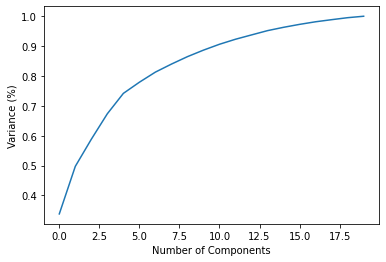

In [64]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [65]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [69]:
model

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [91]:
print(f'Model Score: {model.score(x_test_scaled, y_test)}')

y_predict = model.predict(x_test_scaled)
print(f'Confusion Matrix: \n{confusion_matrix(y_predict, y_test)}')

Model Score: 0.7878405650857719
Confusion Matrix: 
[[ 28   1   0   0   0   0   0   1   0   0   0   1   6   3   2   1   3   0
    2]
 [  3 270   0   1  20  19   0  11   0   0   0   2  19   2   0   0   2   1
    4]
 [  0   1  20   0   0   0   0   0   2   2   0   0   0   0   0   0   0   0
    0]
 [  0   3   0  31   2   0   0   1   0   3   0   0   3   0   0   0   0   1
    0]
 [  5  32   0   0 424  11   0  12   0   0   0   0  13   1   2   1   3   1
    3]
 [  5  25   0   0   8 357   0   4   3   4   0   0  14   1   1   0   6   0
    2]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    1]
 [  9  28   0   3  32  19   2 525   4  22   1   2  58   2  10   2  14  11
    4]
 [  0   0   0   0   0   0   0   1   5   0   0   0   0   0   0   0   0   0
    0]
 [  3  12   0   1   5   8   0   4   0 234   0   2  11   4   6   6  23   0
    2]
 [  1   0   0   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0
    0]
 [  0   1   0   0   0   0   0   2   0   4   0   7   0   1 

In [80]:
print(y_predict)

['male_speech' 'camera' 'appeal' ... 'male_speech' 'footstep' 'slapping']


In [83]:
set(y_predict)

{'appeal',
 'boom',
 'camera',
 'cutter',
 'door',
 'dropping',
 'fight',
 'footstep',
 'glass_break',
 'groan',
 'hush',
 'looting',
 'male_speech',
 'scream',
 'slang',
 'slapping',
 'sob',
 'water',
 'yelling'}

In [93]:
len(confusion_matrix(y_predict, y_test).sum(axis=1))

19

In [74]:
from collections import Counter
Counter(y_predict)

Counter({'male_speech': 805,
         'camera': 25,
         'appeal': 48,
         'dropping': 430,
         'footstep': 748,
         'groan': 321,
         'door': 508,
         'sob': 303,
         'boom': 354,
         'cutter': 44,
         'yelling': 193,
         'water': 86,
         'looting': 18,
         'scream': 38,
         'slapping': 9,
         'slang': 17,
         'hush': 9,
         'glass_break': 6,
         'fight': 2})